# Unsupervised surgery pipeline with interpetable autoencoder EXPIMAP

In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

Global seed set to 0


In [3]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download reference and do preprocessing

In [ ]:
url = 'https://drive.google.com/uc?id=1oKpcxQSm238SMNY77TAR5bzKUMIqgGU_'
output = 'pbmc_vars_sb.h5ad'
gdown.download(url, output, quiet=False)

In [4]:
adata = sc.read('pbmc_vars_sb.h5ad')

Filter out Villani study and put counts to `adata.X`.

In [5]:
adata = adata[adata.obs['study']!='Villani'].copy()

In [6]:
adata.X = adata.layers["counts"].copy()

Read Reactome annotations into the reference dataset, the binary matrix of annotation is in `adata.varm['I']`.

In [ ]:
url = 'https://drive.google.com/uc?id=1DGlbHlZjxT89CrxD0VbtuLBhO43XshMl'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

In [7]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)

Remove all genes which are not present in the Reactome annotations.

In [8]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

For a better model performance it is necessary to select HVGs. We are doing this by applying the `scanpy.pp` function `highly_variable_genes()`. The `n_top_genes` is set to 2000 here. Howeever, if you more complicated datasets you might have to increase number of genes to capture more diversity in the data.

In [9]:
sc.pp.normalize_total(adata)

In [10]:
sc.pp.log1p(adata)

In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

Filter out all annotations which has the number of genes lower than 12.

In [12]:
select_terms = adata.varm['I'].sum(0)>12

In [13]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [14]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

Filter out unannotated genes again.

In [15]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

Put count back to `adata.X`.

In [16]:
adata.X = adata.layers["counts"].copy()

### Create EXPIMAP model and train it on reference dataset

In [17]:
intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 4
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext, ext_m, cond, out:  282 0 0 4 1972
	with hard mask.
Last Decoder layer: softmax


Set the `alpha` hyperparameter, it regulates the strength of group lasso regularization of annotations (terms). Higher value means that higher number of latent variables corresponding to annotations will be deactivated during training depending on their contribution to the reconstruction loss.

In [18]:
ALPHA = 0.7

In [19]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Init the group lasso proximal operator for the main terms.
 |████████------------| 41.8%  - epoch_loss: 875.0875513335 - epoch_recon_loss: 849.8969689248 - epoch_kl_loss: 50.3811637679 - val_loss: 938.5590139536 - val_recon_loss: 912.9722806490 - val_kl_loss: 51.17346543531427418
ADJUSTED LR
 |█████████-----------| 46.0%  - epoch_loss: 867.2534920638 - epoch_recon_loss: 842.2286955321 - epoch_kl_loss: 50.0495922638 - val_loss: 939.3953810472 - val_recon_loss: 913.6503906250 - val_kl_loss: 51.4899893541
ADJUSTED LR
 |██████████----------| 50.5%  - epoch_loss: 868.1691942506 - epoch_recon_loss: 843.1531918455 - epoch_kl_loss: 50.0320032611 - val_loss: 937.6233802209 - val_recon_loss: 911.8207420936 - val_kl_loss: 51.6052835905
ADJUSTED LR
 |████████████--------| 60.2%  - epoch_loss: 874.0884924476 - epoch_recon_loss: 848.9184943453 - epoch_kl_loss: 50.3399958715 - val_loss: 938.2763272799 - val_recon_loss: 912.5495535044 - val_kl_loss: 51.4535569411
ADJUSTED LR
 |████████████--------| 63

What annotations were deactivated during training.

In [20]:
inactive_idx = ~intr_cvae.nonzero_terms()

In [21]:
print('Inactive terms:')
[term for i, term in enumerate(adata.uns['terms']) if inactive_idx[i]]

Inactive terms:


['PYRUVATE_METABOLISM_AND_CITRIC',
 'SIGNALING_BY_WNT',
 'NEF_MEDIATES_DOWN_MODULATION_O',
 'SPHINGOLIPID_DE_NOVO_BIOSYNTHE',
 'NUCLEAR_SIGNALING_BY_ERBB4',
 'RIP_MEDIATED_NFKB_ACTIVATION_V',
 'RORA_ACTIVATES_CIRCADIAN_EXPRE',
 'YAP1_AND_WWTR1_TAZ_STIMULATED_',
 'EXTRACELLULAR_MATRIX_ORGANIZAT',
 'SMAD2_SMAD3_SMAD4_HETEROTRIMER',
 'DOWNREGULATION_OF_SMAD2_3_SMAD',
 'HEPARAN_SULFATE_HEPARIN_HS_GAG',
 'SIGNALING_BY_FGFR_MUTANTS',
 'NUCLEAR_EVENTS_KINASE_AND_TRAN',
 'PHOSPHORYLATION_OF_CD3_AND_TCR',
 'NRAGE_SIGNALS_DEATH_THROUGH_JN',
 'PHASE1_FUNCTIONALIZATION_OF_CO',
 'CA_DEPENDENT_EVENTS',
 'INTEGRIN_ALPHAIIB_BETA3_SIGNAL',
 'P53_DEPENDENT_G1_DNA_DAMAGE_RE',
 'RNA_POL_II_TRANSCRIPTION_PRE_I',
 'M_G1_TRANSITION',
 'NCAM_SIGNALING_FOR_NEURITE_OUT',
 'FORMATION_OF_RNA_POL_II_ELONGA',
 'SMOOTH_MUSCLE_CONTRACTION',
 'ACTIVATION_OF_NMDA_RECEPTOR_UP',
 'POST_NMDA_RECEPTOR_ACTIVATION_',
 'ACTIVATION_OF_KAINATE_RECEPTOR',
 'ACTIVATED_TAK1_MEDIATES_P38_MA',
 'DEPOSITION_OF_NEW_CENPA_CONTAI',
 'RE

In [22]:
MEAN = False

Plot the latent space of the reference.

In [23]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [24]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [25]:
sc.tl.umap(adata)

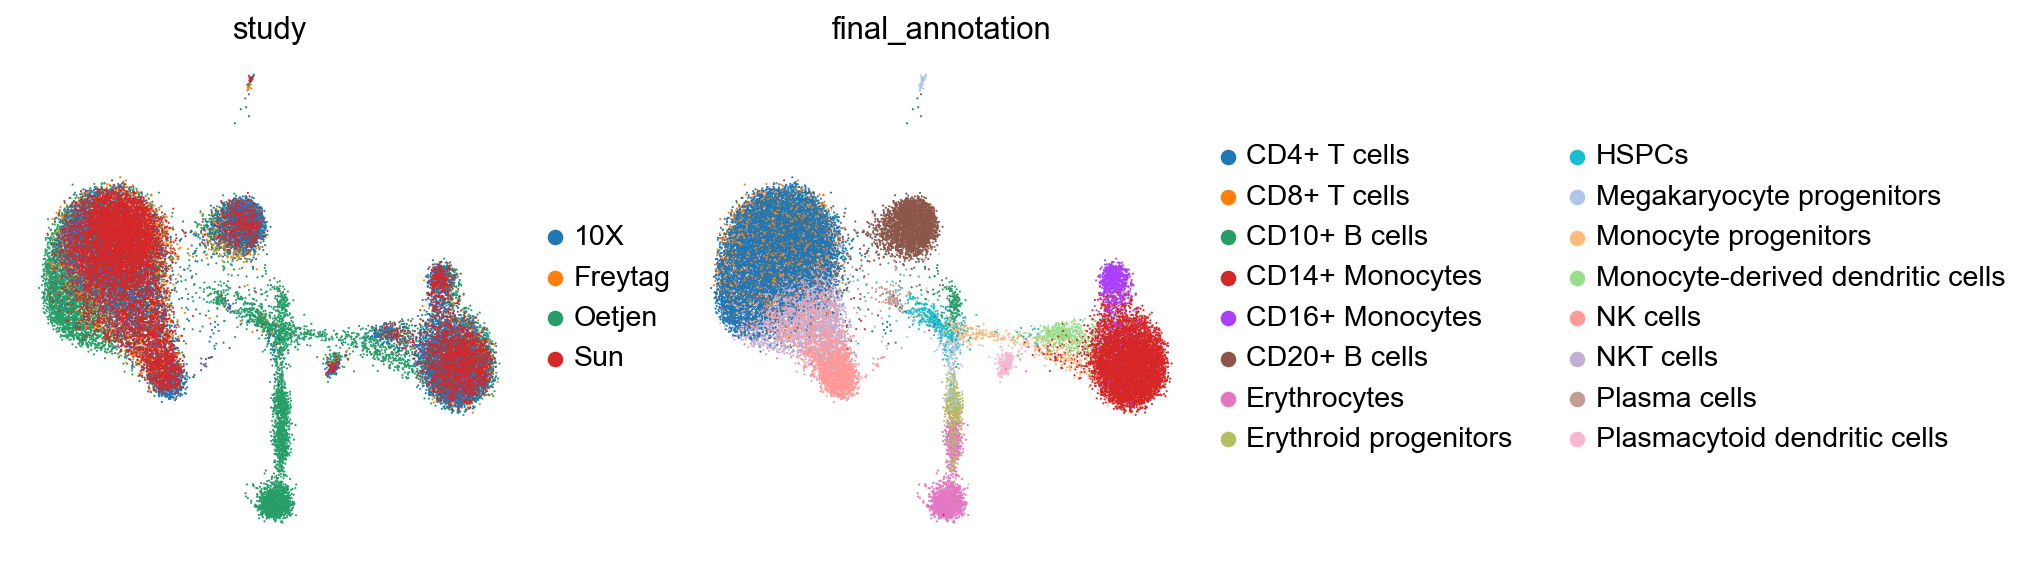

In [26]:
sc.pl.umap(adata, color=['study', 'final_annotation'], frameon=False)

### Download query and do surgery

In [ ]:
url = 'https://drive.google.com/uc?id=1wg_21to_sNzDmoWq6vOxWdG4-9ZWldql'
output = 'kang_count.h5ad'
gdown.download(url, output, quiet=False)

In [27]:
kang = sc.read('kang_count.h5ad')[:, adata.var_names].copy()

In [28]:
kang.obs['study'] = 'Kang'

In [29]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(kang, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 282
Decoder Architecture:
	Masked linear layer in, ext, ext_m, cond, out:  282 0 0 5 1972
	with hard mask.
Last Decoder layer: softmax


In [30]:
q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)

 |████████------------| 41.2%  - val_loss: 519.4205793901 - val_recon_loss: 512.4798778187 - val_kl_loss: 69.40706010300
ADJUSTED LR
 |████████------------| 43.0%  - val_loss: 520.2541309703 - val_recon_loss: 513.2979486639 - val_kl_loss: 69.5618133545
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 150


Save your model.

In [ ]:
q_intr_cvae.save('query_kang_tutorial')

In [32]:
kang.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

Plot the latent space of the query.

In [33]:
sc.pp.neighbors(kang, use_rep='X_cvae')

In [34]:
sc.tl.umap(kang)

... storing 'study' as categorical


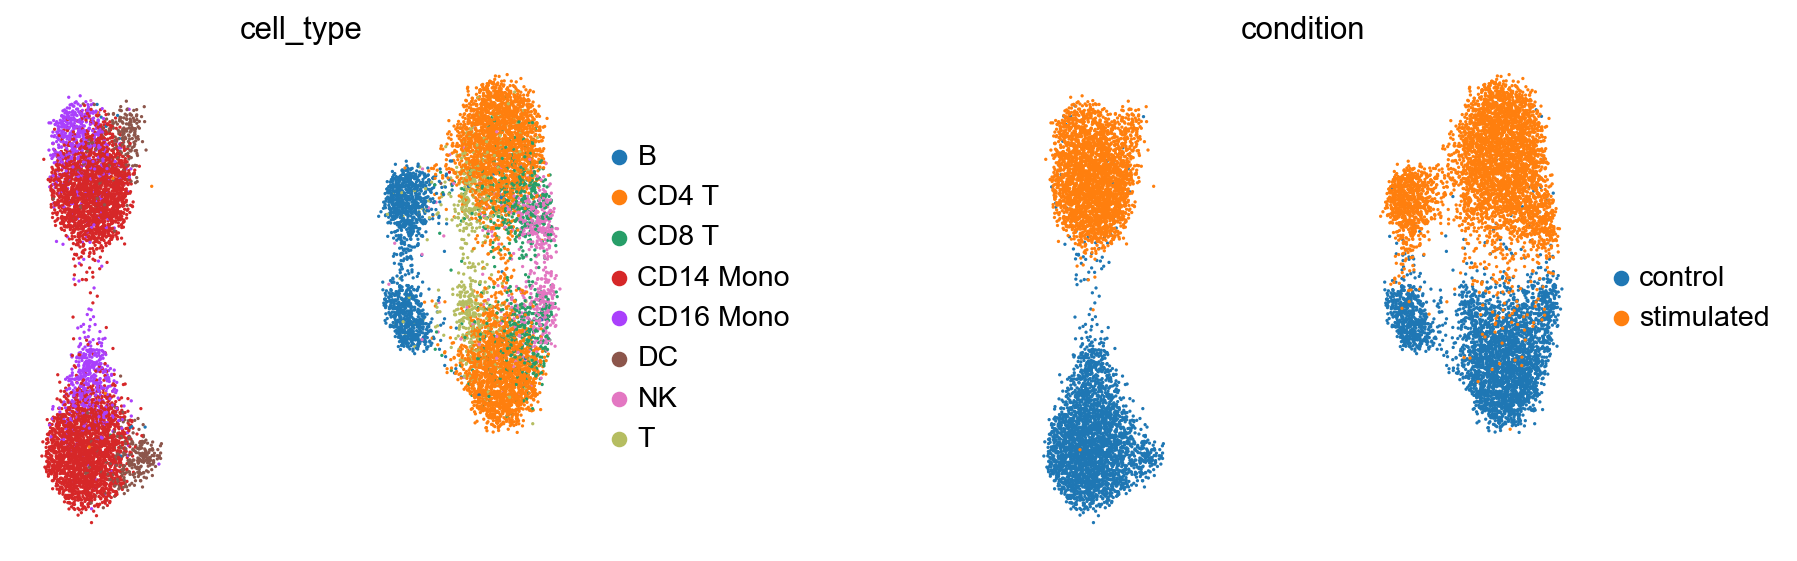

In [35]:
sc.pl.umap(kang, color=['cell_type', 'condition'], frameon=False, wspace=0.6)

### Get latent representation of reference + query dataset

In [36]:
kang_pbmc = sc.AnnData.concatenate(adata, kang, batch_key='batch_join')

In [37]:
kang_pbmc.uns['terms'] = adata.uns['terms']

In [38]:
kang_pbmc.obsm['X_cvae'] = q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN)[:, ~inactive_idx]

In [39]:
sc.pp.neighbors(kang_pbmc, use_rep='X_cvae')
sc.tl.umap(kang_pbmc)

In [40]:
kang_pbmc.strings_to_categoricals()

... storing 'batch' as categorical
... storing 'chemistry' as categorical
... storing 'data_type' as categorical
... storing 'final_annotation' as categorical
... storing 'sample_ID' as categorical
... storing 'species' as categorical
... storing 'study' as categorical
... storing 'tissue' as categorical
... storing 'orig.ident' as categorical
... storing 'stim' as categorical
... storing 'seurat_annotations' as categorical
... storing 'condition' as categorical
... storing 'cell_type' as categorical


Create joint cell types for the reference and the query.

In [41]:
kang_pbmc.obs['cell_type_joint'] = kang_pbmc.obs['final_annotation'].tolist()

In [42]:
idx_1 = kang_pbmc.obs['cell_type_joint'].astype(str) == 'nan'
idx_2 = kang_pbmc.obs['cell_type'].astype(str) != 'nan'
kang_pbmc.obs['cell_type_joint'][idx_1] = kang_pbmc.obs['cell_type'][idx_2].tolist()

In [43]:
categories = np.unique(kang_pbmc.obs['cell_type_joint'])

In [44]:
celltypes_replace = {}
celltypes_replace['CD20+ B cells'] = 'B'
celltypes_replace['CD4 T'] = 'CD4+ T cells'
celltypes_replace['CD8 T'] = 'CD8+ T cells'
celltypes_replace['CD14 Mono'] = 'CD14+ Monocytes'
celltypes_replace['CD16 Mono'] = 'CD16+ Monocytes'
celltypes_replace['NK'] = 'NK cells'

In [45]:
for cat in categories:
    if cat in celltypes_replace:
        kang_pbmc.obs['cell_type_joint'][kang_pbmc.obs['cell_type_joint']==cat] = celltypes_replace[cat]

In [46]:
kang_pbmc.obs['condition_joint'] = kang_pbmc.obs.condition.astype(str)
kang_pbmc.obs['condition_joint'][kang_pbmc.obs['condition_joint'].astype(str)=='nan']='control'

... storing 'cell_type_joint' as categorical
... storing 'condition_joint' as categorical


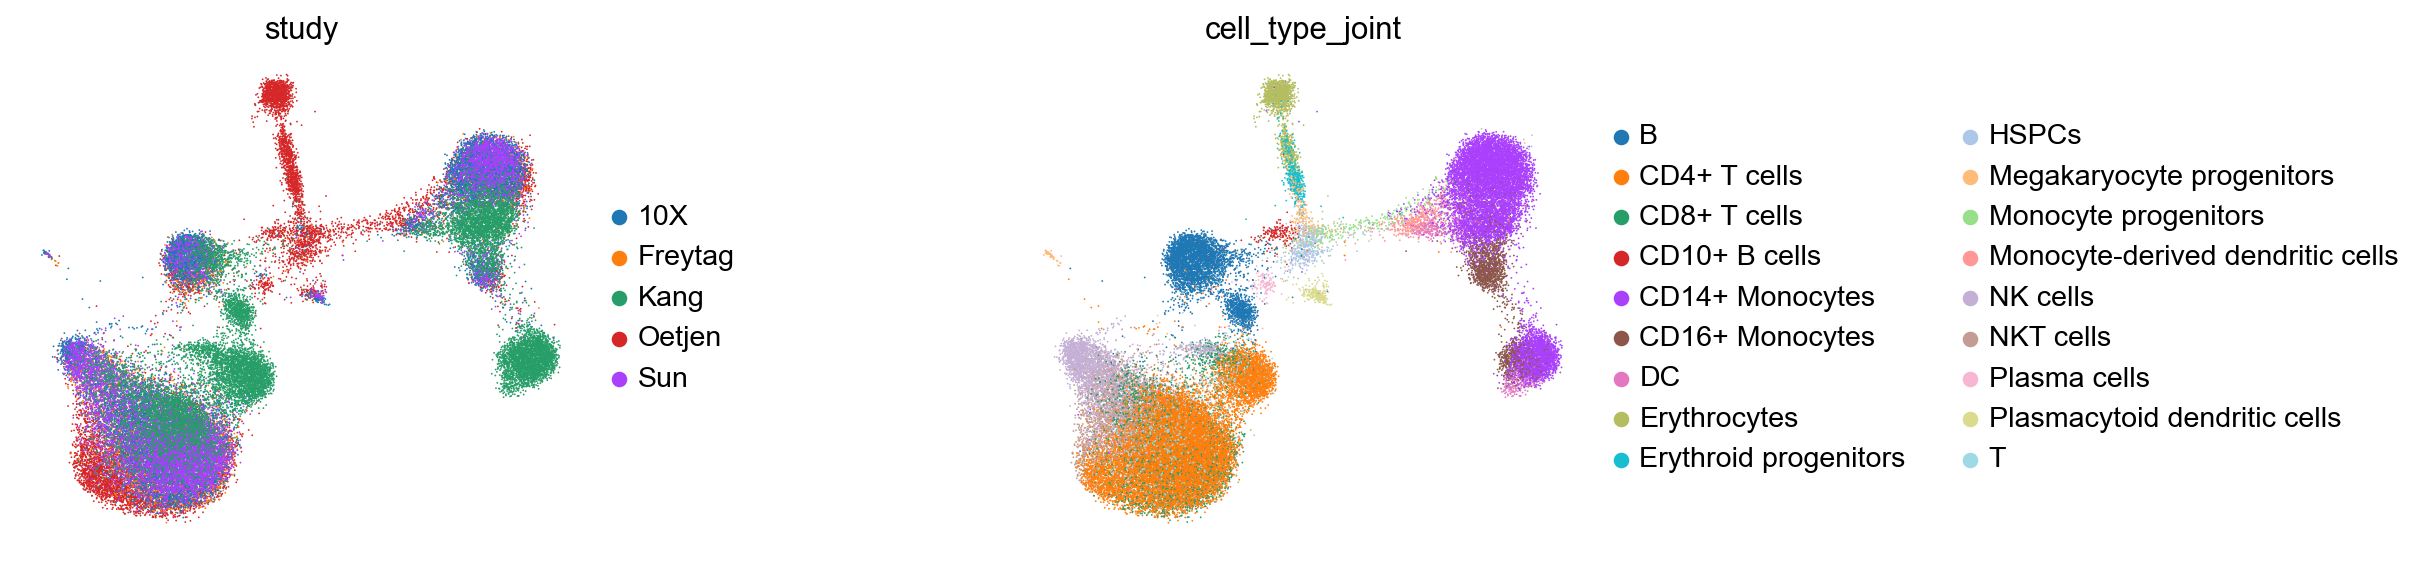

In [47]:
sc.pl.umap(kang_pbmc, color=['study', 'cell_type_joint'], frameon=False, wspace=0.6)

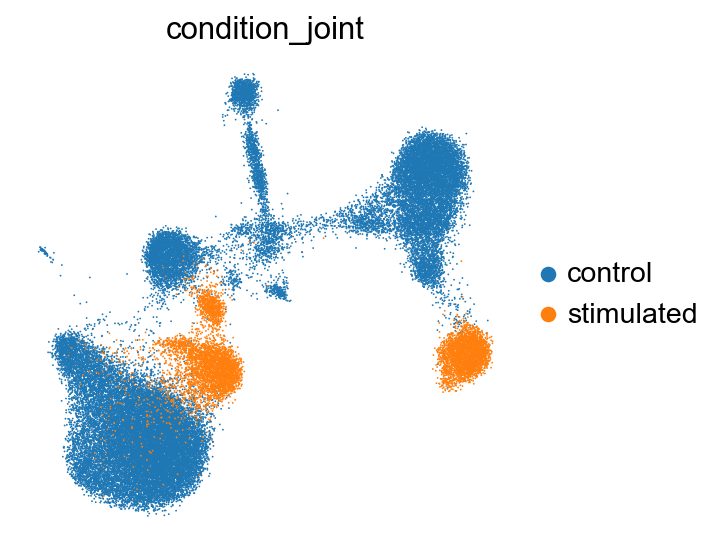

In [48]:
sc.pl.umap(kang_pbmc, color='condition_joint', frameon=False, wspace=0.6)

Do gene set enrichment test for condition in reference + query.

In [49]:
q_intr_cvae.latent_directions(adata=kang_pbmc)

In [50]:
q_intr_cvae.latent_enrich(groups='condition_joint', comparison='control', use_directions=True, adata=kang_pbmc)

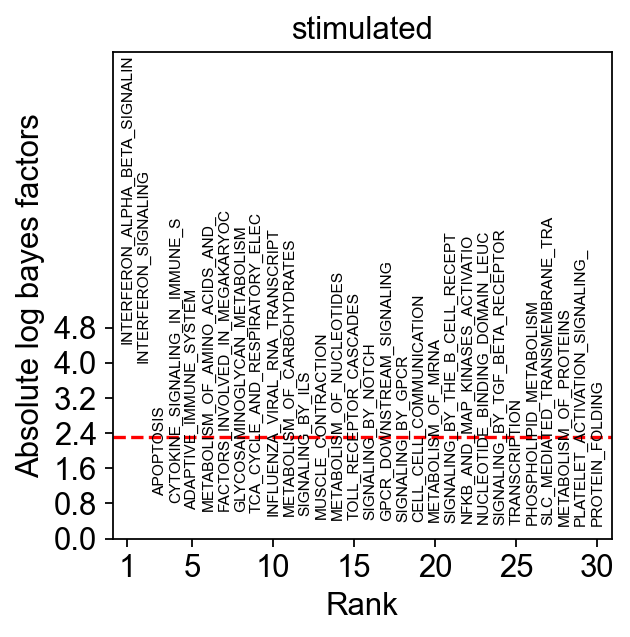

In [51]:
fig = sca.plotting.plot_abs_bfs(kang_pbmc, yt_step=0.8, scale_y=2.5, fontsize=7)

Plot the latent variables for query + reference corresponding to the annotations 'INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPTOR', 'INTERFERON_ALPHA_BETA_SIGNALING'.

In [52]:
terms = kang_pbmc.uns['terms']
idx = [terms.index(term) for term in ['INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPT', 'INTERFERON_ALPHA_BETA_SIGNALIN']]

In [53]:
latents = (q_intr_cvae.get_latent(kang_pbmc.X, kang_pbmc.obs['study'], mean=MEAN) * kang_pbmc.uns['directions'])[:, idx]

In [54]:
kang_pbmc.obs['INTERFERON_SIGNALING'] = latents[:, 0]
kang_pbmc.obs['SIGNALING_BY_THE_B_CELL_RECEPT'] = latents[:, 1]
kang_pbmc.obs['INTERFERON_ALPHA_BETA_SIGNALIN'] = latents[:, 2]

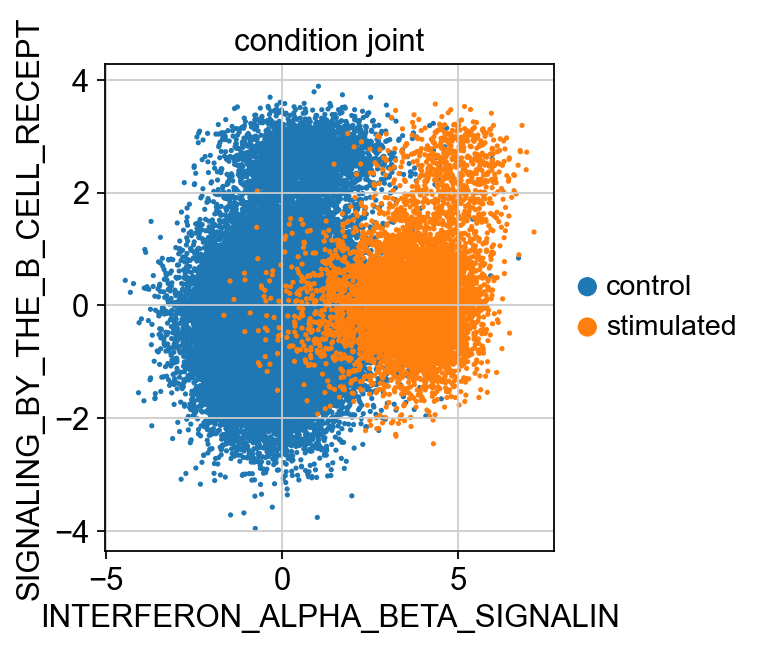

In [55]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=22)

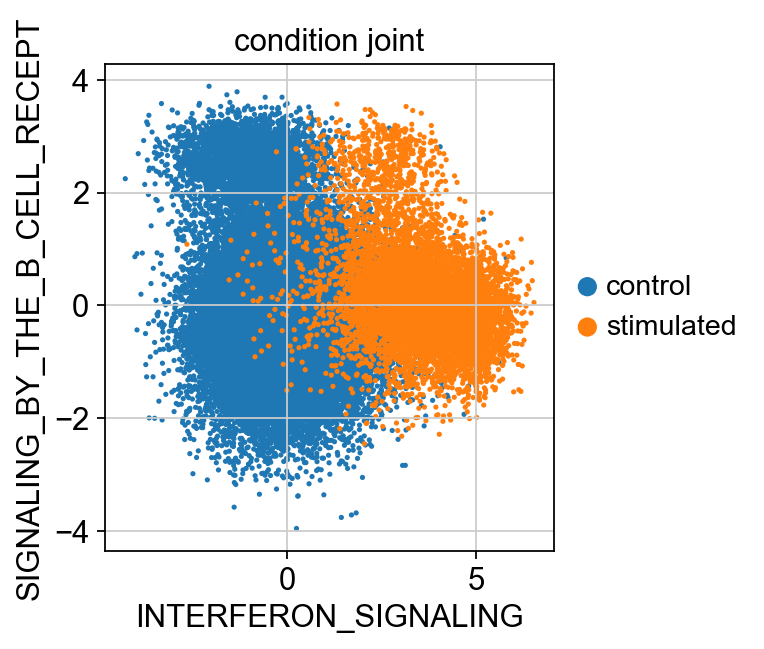

In [56]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_SIGNALING', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='condition_joint', size=22)

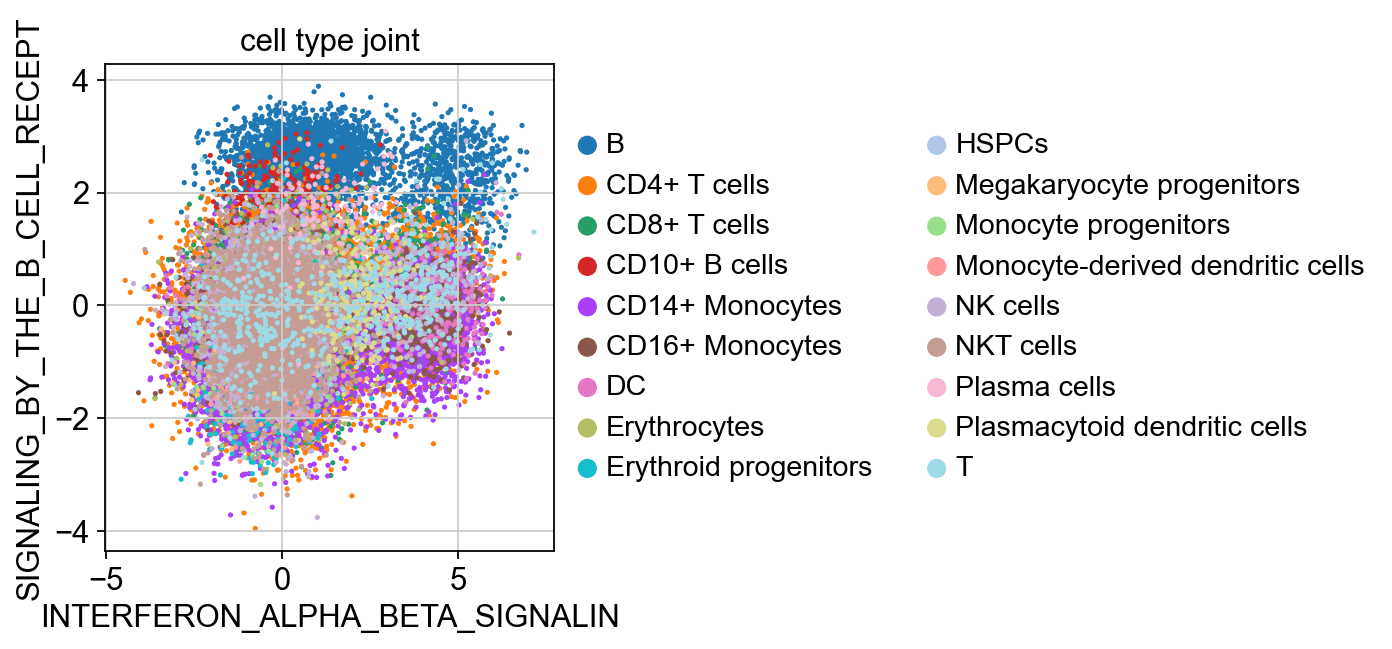

In [57]:
sc.pl.scatter(kang_pbmc, x='INTERFERON_ALPHA_BETA_SIGNALIN', y='SIGNALING_BY_THE_B_CELL_RECEPT', color='cell_type_joint', size=22)